In [ ]:
!pip install mlflow

In [10]:
import timm
import mlflow
import os
from typing import Literal, Callable

import torch 
from torch import nn 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, RMSprop
from torch.optim.optimizer import Optimizer

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
device

'cuda'

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [14]:
train_data_link = "/kaggle/input/intel-image-classification/seg_train/seg_train"
train_data = datasets.ImageFolder(root=train_data_link, transform=train_transforms)

val_data_link = "/kaggle/input/intel-image-classification/seg_test/seg_test"
val_data = datasets.ImageFolder(root=val_data_link, transform=val_transforms)

In [15]:
len(train_data)

14034

In [16]:
len(train_data.classes)

6

In [17]:
def output(data, limit):
    names = data.classes
    for i, (x, y) in enumerate(data):
        x = x.permute(1, 2, 0).cpu().numpy()
        
        plt.imshow(x)
        plt.title(names[int(y)])
        plt.show()
    
    
        if i+1 == limit:
            break

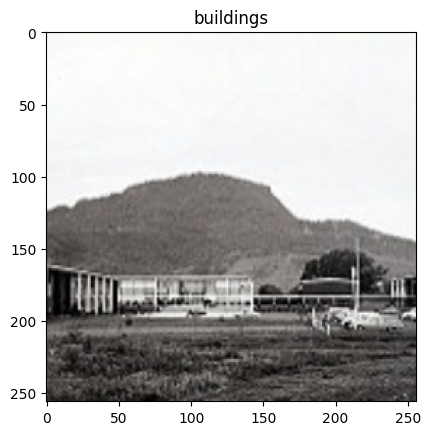

In [18]:
output(train_data, 1)

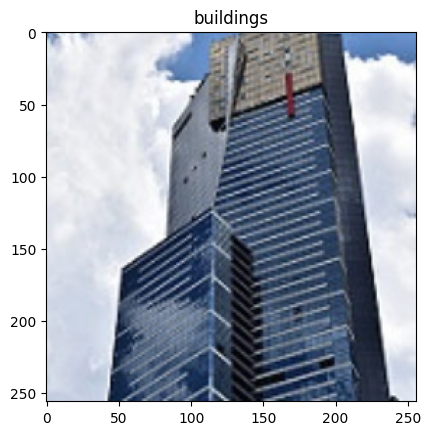

In [19]:
output(val_data, 1)

In [20]:
batch_size = 64

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [21]:
def train(model, train_dl, val_dl, optimizer, loss_fn, accuracy, f1, epochs, device):
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],

        "val_loss": [],
        "val_acc": [],
        "val_f1": []
    }


    for epoch in range(epochs):

        model.train()
        total_train_loss = 0.0
        total_train_labels = []
        total_train_preds = []

        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            preds = model(x)

            loss = loss_fn(preds, y)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            upd_preds = torch.argmax(preds, dim=1)

            total_train_labels.extend(y.cpu().numpy())
            total_train_preds.extend(upd_preds.cpu().numpy())

        train_acc = accuracy(total_train_labels, total_train_preds)
        train_f1 = f1(total_train_labels, total_train_preds, average="macro")
        total_train_loss /= len(train_dl)

        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("train_f1", train_f1, step=epoch)
        mlflow.log_metric("train_loss", total_train_loss, step=epoch)

        model.eval()
        total_val_loss = 0.0
        total_val_labels = []
        total_val_preds = []

        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)

                preds = model(x)
                loss = loss_fn(preds, y)
                total_val_loss += loss.item()

                upd_preds = torch.argmax(preds, dim=1)
                
                total_val_labels.extend(y.cpu().numpy())
                total_val_preds.extend(upd_preds.cpu().numpy())

        total_val_loss /= len(val_dl)
        val_acc = accuracy(total_val_labels, total_val_preds)
        val_f1 = f1(total_val_labels, total_val_preds, average="macro")

        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        mlflow.log_metric("val_loss", total_val_loss, step=epoch)


        history["train_loss"].append(total_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        

        history["val_loss"].append(total_val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        

        print(f'Epoch: {epoch+1}; Loss: {total_train_loss:.4f}; Accuracy: {train_acc:.4f}; F1_score: {train_f1:.4f}; Val_loss: {total_val_loss:.4f}; Val_acc: {val_acc:.4f}; Val_f1: {val_f1:.4f}')
    
    mlflow.end_run()
    return history

In [22]:
os.environ["USER"] = "Maks Kucher"

In [23]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_tracking_uri("file:/kaggle/working/mlruns")
mlflow.set_experiment("custom_resnet")


2025/08/29 10:47:10 INFO mlflow.tracking.fluent: Experiment with name 'custom_resnet' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///kaggle/working/mlruns/236767286142523661', creation_time=1756464430434, experiment_id='236767286142523661', last_update_time=1756464430434, lifecycle_stage='active', name='custom_resnet', tags={}>

In [24]:
print(timm.list_models("resnet*"))    

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_clip', 'resnet50_clip_gap', 'resnet50_gn', 'resnet50_mlp', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet50x4_clip', 'resnet50x4_clip_gap', 'resnet50x16_clip', 'resnet50x16_clip_gap', 'resnet50x64_clip', 'resnet50x64_clip_gap', 'resnet51q', 'resnet61q', 'resnet101', 'resnet101_clip', 'resnet101_clip_gap', 'resnet101c', 'resnet101d', 'resnet101s', 'resnet152', 'resnet152c', 'resnet152d', 'resnet152s', 'resnet200', 'resnet200d', 'resnetaa34d', 'resnetaa50', 'resnetaa50d', 'resnetaa101d', 'resnetblur18', 'resnetblur50', 'resnetblur50d', 'resnetblur101d', 'resnetrs50', 'resnetrs101', 'resnetrs152', 'resnetrs200', 'resnetrs270', 'resnetrs350', 'resnetrs420', 'resnetv2_18', 'resnetv2_18d', 'resnetv2_34', 'resnetv2_34d', 'resnetv2_50', 'resnetv2_50d', 'resnetv2_50d_evos', 'resnetv2_50d_frn', 'resnetv2_50d_gn', 'resnet

In [25]:
class CustomNet(nn.Module):
    def __init__(self, backbone, drop_value, n_inside, act: Literal["ReLU", "Leaky_RelU"]):
        super().__init__()

        self.backbone = backbone
        self.act = nn.Identity()
        
        if act =="ReLU":
            self.act = nn.ReLU()
        elif act == "Leaky_ReLU":
            self.act = nn.LeakyReLU()

        self.net = nn.Sequential(
            self.backbone,
            nn.Linear(self.backbone.num_features, n_inside),
            self.act,
            nn.Dropout(drop_value),
            
            nn.Linear(n_inside, n_inside//2),
            self.act,
            nn.Dropout(drop_value),
        
            nn.Linear(n_inside//2, 6)
        )

    def forward(self, x):
        return self.net(x)
        

In [26]:
backbone = timm.create_model("resnet18", pretrained=True, num_classes=0)
model = CustomNet(backbone, 0.3, 256, "ReLU")
tensor = torch.randn(1, 3, 256, 256)

out = model(tensor)
out.shape

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

torch.Size([1, 6])

In [27]:
def run(model_name: Literal["resnet18", "resnet34", "resnet50"], 
        
        run_name: str, 
        train_dl: DataLoader, 
        val_dl: DataLoader, 
        loss_fn: nn.Module, 
        optimizer: Optimizer,
        lr: int,
        accuracy: Callable, 
        f1: Callable, 
        epochs: int, 
        device: str,
       
        drop_value: int,
        n_inside: int,
        act: Literal["ReLU", "Leaky_RelU"]):

    with mlflow.start_run(run_name = run_name):

        mlflow.log_param("model_name", model_name)
        mlflow.log_param("drop_value", drop_value)
        mlflow.log_param("neuros_inside", n_inside)
        mlflow.log_param("activation", act)
        
        backbone = timm.create_model(model_name, pretrained=True, num_classes=0)

        for param in backbone.parameters():
            param.requires_grad = False

       
        model = CustomNet(backbone, drop_value, n_inside, act)
        model.to(device)
    
        mlflow.log_param("optimizer", optimizer.__class__.__name__)
        mlflow.log_param("loss_function", loss_fn.__class__.__name__)
        mlflow.log_param("epochs", epochs)

        optim = optimizer(model.parameters(), lr=lr)
        
        history = train(model, train_dl, val_dl, optim, loss_fn, accuracy, f1, epochs, device)

        return history
    

In [28]:
history = run(model_name = "resnet18", 
    run_name = "resnet_run_1",
    train_dl = train_dl,
    val_dl = val_dl, 
    loss_fn = nn.CrossEntropyLoss(), 
    optimizer = Adam, 
    lr = 1e-3,
    accuracy = accuracy_score, 
    f1 = f1_score,
    epochs = 15,
    device = device,
    drop_value = 0.3,
    n_inside = 256,
    act = "ReLU")

100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


Epoch: 1; Loss: 0.6172; Accuracy: 0.7716; F1_score: 0.7741; Val_loss: 0.3507; Val_acc: 0.8693; Val_f1: 0.8713


100%|██████████| 47/47 [00:12<00:00,  3.84it/s]


Epoch: 2; Loss: 0.3483; Accuracy: 0.8725; F1_score: 0.8744; Val_loss: 0.3107; Val_acc: 0.8863; Val_f1: 0.8882


100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


Epoch: 3; Loss: 0.3068; Accuracy: 0.8884; F1_score: 0.8902; Val_loss: 0.2986; Val_acc: 0.8907; Val_f1: 0.8930


100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


Epoch: 4; Loss: 0.2988; Accuracy: 0.8909; F1_score: 0.8924; Val_loss: 0.2813; Val_acc: 0.8940; Val_f1: 0.8966


100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


Epoch: 5; Loss: 0.2839; Accuracy: 0.8948; F1_score: 0.8964; Val_loss: 0.2849; Val_acc: 0.8933; Val_f1: 0.8955


100%|██████████| 47/47 [00:11<00:00,  4.02it/s]


Epoch: 6; Loss: 0.2834; Accuracy: 0.8975; F1_score: 0.8990; Val_loss: 0.2809; Val_acc: 0.8933; Val_f1: 0.8959


100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


Epoch: 7; Loss: 0.2731; Accuracy: 0.8984; F1_score: 0.9001; Val_loss: 0.2738; Val_acc: 0.9017; Val_f1: 0.9036


100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


Epoch: 8; Loss: 0.2548; Accuracy: 0.9060; F1_score: 0.9076; Val_loss: 0.2853; Val_acc: 0.8873; Val_f1: 0.8892


100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


Epoch: 9; Loss: 0.2566; Accuracy: 0.9055; F1_score: 0.9070; Val_loss: 0.2753; Val_acc: 0.8947; Val_f1: 0.8977


100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Epoch: 10; Loss: 0.2470; Accuracy: 0.9093; F1_score: 0.9108; Val_loss: 0.2950; Val_acc: 0.8903; Val_f1: 0.8921


100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Epoch: 11; Loss: 0.2468; Accuracy: 0.9070; F1_score: 0.9086; Val_loss: 0.2557; Val_acc: 0.9040; Val_f1: 0.9061


100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


Epoch: 12; Loss: 0.2444; Accuracy: 0.9094; F1_score: 0.9109; Val_loss: 0.2827; Val_acc: 0.8903; Val_f1: 0.8921


100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


Epoch: 13; Loss: 0.2422; Accuracy: 0.9096; F1_score: 0.9110; Val_loss: 0.2694; Val_acc: 0.9013; Val_f1: 0.9033


100%|██████████| 47/47 [00:11<00:00,  3.95it/s]


Epoch: 14; Loss: 0.2246; Accuracy: 0.9162; F1_score: 0.9176; Val_loss: 0.2666; Val_acc: 0.9013; Val_f1: 0.9037


100%|██████████| 47/47 [00:11<00:00,  3.96it/s]

Epoch: 15; Loss: 0.2300; Accuracy: 0.9144; F1_score: 0.9158; Val_loss: 0.3098; Val_acc: 0.8870; Val_f1: 0.8892
